# Classifiez automatiquement des biens de consommation : 
*Notebook mission 1 - techniques traitement d'images*

**Etudiez la faisabilité d'un moteur de classification d'articles**

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégo

Objectif : Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image comme dans l’illustration ci-dessous.rie.

**3 et 4 parties de la mission :**

Faisabilité de classification - techniques traitement d'images basiques

- Analysez les images via différentes méthodes de transformation (niveau de gris, filtrage bruit, contraste etc.).
- Utilisez des algorithmes d'extraction d'e features d’images comme SIFT.
- Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles. 

Faisabilité de classification - techniques traitement d'images plus avancées

- Reprenez la démarche précédente en utilisant cette fois-ci des réseaux de neurones pré-entraînés. 
- Comparez vos résultats avec ceux des méthodes de traitement d’image plus basiques.

In [238]:
# fonctions personnelles pour le pré traitement des données textuelles
import pre_treatment_text as ptt

import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm

import sklearn

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

import timeit
import time

from collections import defaultdict
from collections import Counter

import PIL
from PIL import Image
from PIL import ImageEnhance

import cv2

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)

print("sklearn version", sklearn.__version__)

print("PIL version", PIL.__version__)
print("cv2 version", cv2.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
sklearn version 1.6.1
PIL version 10.2.0
cv2 version 4.11.0


## 1 - Pré traitement du dataset

**Chargement des données**

In [4]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/flipkart_com-ecommerce_sample_1050.csv", \
                   sep=',', low_memory=False)
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Dans ce dataset, nous utiliserons uniquement les noms des produits (product_name), les catégories de premier niveau (transformation de product_category_tree), les noms des fichiers d'image (image).

**Préparation de la variable catégorielle cible**

Transformons la catégorie pour conserver uniquement le 1er niveau :

In [6]:
y = data['product_category_tree']
y

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [8]:
# Appliquer la méthode split sur chaque élément de la colonne
y = data['product_category_tree'].apply(lambda x: ptt.clean_category_first_level(x))
y

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: product_category_tree, Length: 1050, dtype: object

## 2 - Analyse d'une image

### 2.1 - Premières manipulations

In [21]:
# Charger l'image
img = Image.open("C:/Users/admin/Documents/Projets/Projet_6/data_projet/Dataset+projet+prétraitement+textes+images/Flipkart/Images/b0229d4466ac60c7ba53c7ce9fabad7c.jpg") 

# Afficher l'image chargée
img.show()

**Quelle est la taille de notre image, donnée en nombre de pixels :**

In [24]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 1098 px, hauteur : 1100 px


**Regardons les valeurs des pixels**

In [28]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : RGB
Valeur du pixel situé en (20,100) : (208, 206, 207)


Le format utilisé est RGB pour une photo en couleur (3x8-bit pixels, true color - Rouge-vert-bleu).

Nous pouvons récupérer d'un seul coup les valeurs de tous les pixels de l'image à l'aide de la bibliothèque numpy :

In [33]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)
mat

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (1100, 1098, 3)


Matrice à 3 dimensions pour les valeurs de R, G, B

**Convertissons l'image en niveau de gris**

In [198]:
img = img.convert("L")

In [200]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : L
Valeur du pixel situé en (20,100) : 207


In [211]:
# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Taille de la matrice de pixels : (1100, 1098)


En niveau de gris, on se retrouve avec une matrice en 2 dimensions.

### 2.2 - Premiers traitements d'images

**Histogramme de l'image non modifiée**

On part de la matrice "mat" généré via numpy à partir de l'objet Image.

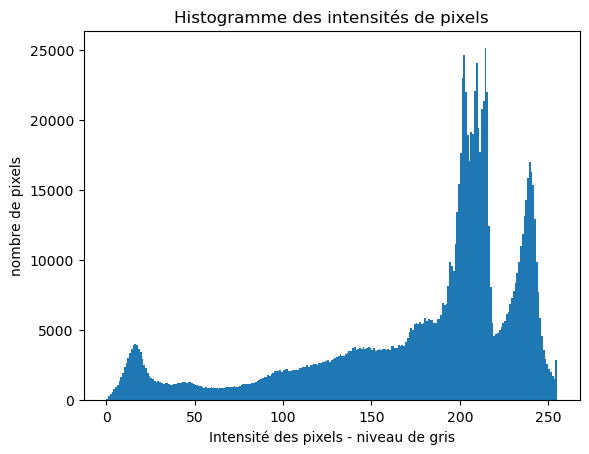

In [234]:
# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(mat.flatten(), bins=range(256))

# Ajouter des labels pour les axes
plt.xlabel("Intensité des pixels - niveau de gris")  # Label pour l'axe X
plt.ylabel("nombre de pixels")                       # Label pour l'axe Y

# Titre de l'histogramme (optionnel)
plt.title("Histogramme des intensités de pixels")

plt.show()

- 0 : noir
- 250 : blanc

On voit que l'image tire plus vers le blanc (clair) que vers le noir (sombre).

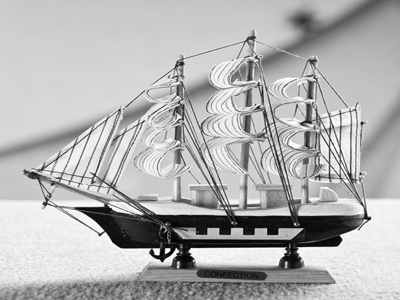

In [228]:
# Redimensionner l'image pour l'affichage
img_resized = img.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

**Correction de l'exposition**

Une première application consiste à corriger la luminosité, ou exposition, de l'image.

Image sous-exposée :

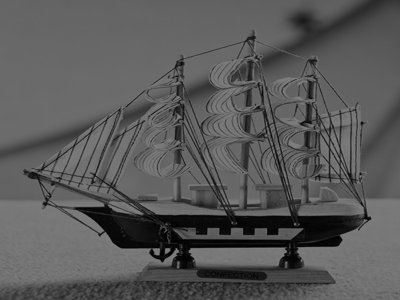

In [250]:
# Créer un objet ImageEnhance pour la luminosité
enhancer = ImageEnhance.Brightness(img)

# Ajuster l'exposition (facteur > 1 augmente, facteur < 1 diminue)
facteur = 0.5  # Par exemple : 1.5 pour augmenter, 0.5 pour réduire
image_exposee = enhancer.enhance(facteur)

# Afficher ou enregistrer l'image modifiée
img_resized = image_exposee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

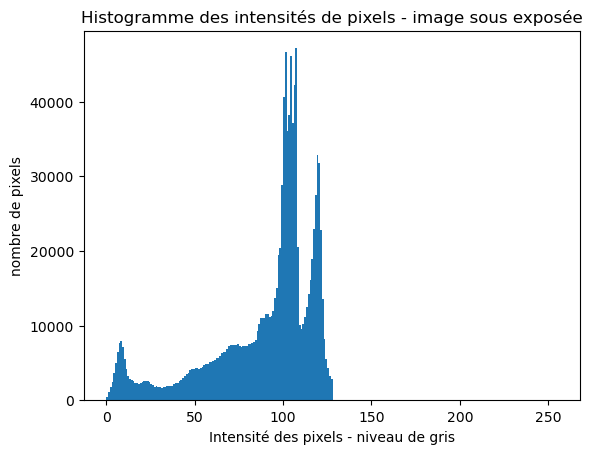

In [252]:
mat = np.array(image_exposee)
n, bins, patches = plt.hist(mat.flatten(), bins=range(256))

# Ajouter des labels pour les axes
plt.xlabel("Intensité des pixels - niveau de gris")  # Label pour l'axe X
plt.ylabel("nombre de pixels")                       # Label pour l'axe Y

# Titre de l'histogramme (optionnel)
plt.title("Histogramme des intensités de pixels - image sous exposée")

plt.show()

On voit clairement le décalage vers le noir (0).

Image sur-exposée :

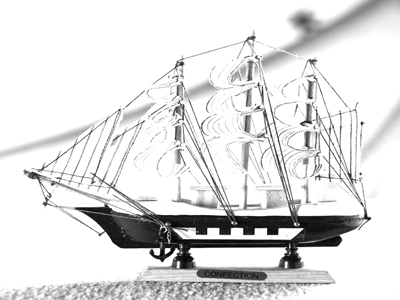

In [264]:
# Créer un objet ImageEnhance pour la luminosité
enhancer = ImageEnhance.Brightness(img)

# Ajuster l'exposition (facteur > 1 augmente, facteur < 1 diminue)
facteur = 1.5  # Par exemple : 1.5 pour augmenter, 0.5 pour réduire
image_exposee = enhancer.enhance(facteur)

# Afficher ou enregistrer l'image modifiée
img_resized = image_exposee.resize((400, 300))  # Spécifiez la largeur et la hauteur
img_resized

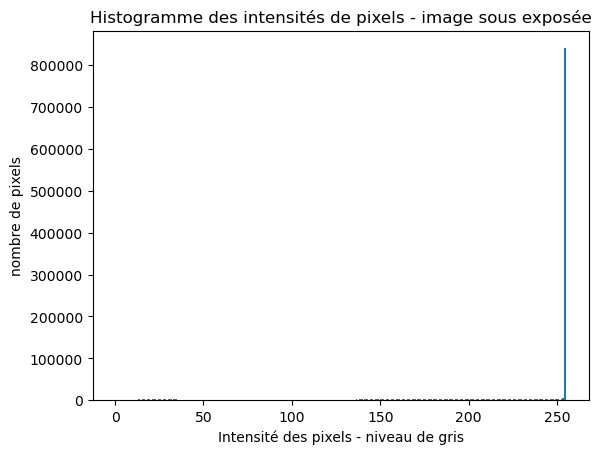

In [266]:
mat = np.array(image_exposee)
n, bins, patches = plt.hist(mat.flatten(), bins=range(256))

# Ajouter des labels pour les axes
plt.xlabel("Intensité des pixels - niveau de gris")  # Label pour l'axe X
plt.ylabel("nombre de pixels")                       # Label pour l'axe Y

# Titre de l'histogramme (optionnel)
plt.title("Histogramme des intensités de pixels - image sous exposée")

plt.show()

L'image est dominée par le blanc.